In [95]:
import pandas as pd
import numpy as np

### Question 6

In [96]:
data=pd.read_excel('data_scoring.xlsx', index_col=False, header=0)
print(data)

       ID  Year  Default      WCTA      RETA   EBIT_TA      METL       STA
0       1  1999        1  0.500799  0.306846  0.043373  0.956271  0.334774
1       1  2000        1  0.547780  0.322214  0.051843  1.064545  0.334591
2       1  2001        1  0.451001  0.225150  0.026813  0.804096  0.245585
3       1  2002        1  0.306887  0.191936  0.030058  0.387010  0.253438
4       1  2003        1  0.447246  0.217368  0.032458  0.791639  0.275531
...   ...   ...      ...       ...       ...       ...       ...       ...
3995  826  1997        0  0.028728 -1.846117  0.033956  0.034680  0.678044
3996  827  2000        0  0.172167 -0.068613 -0.004699  0.043519  0.235299
3997  828  1996        0  0.005588 -0.260068  0.036878  0.298255  0.148100
3998  829  2001        0 -0.994230 -0.433532 -0.000244  0.035502  0.330467
3999  830  2002        0  0.065566 -0.113739  0.036024  0.037632  0.116360

[4000 rows x 8 columns]


In [97]:
#préparation data

# WCTA,RETA, EBITTA, METL, STA
data1=data.iloc[:,3:]

# WCTA, RETA, EBITTA, STA
data2=data1.drop(columns=['METL'],inplace=False,axis=1)

# METL, EBITTA
data3=data.loc[:,['METL','EBIT_TA']]

# WCTA,RETA
data4=data.loc[:,['WCTA','RETA']]

data_rassemble={1:data1, 2:data2, 3:data3, 4:data4}

In [53]:
# Recherche des valeurs aberrantes dans la colonne 'Default' qui ne contient en théorie que du 1 et 0
for i,element in enumerate(data['Default']):
    if element not in [0,1]: 
        print(i, element)
    else:
        break
print("Pas de valeur aberrante in 'Default'")    

Pas de valeur aberrante in 'Default'


In [58]:
#recherche des valeurs manquantes
valeurs_manquantes=data.isnull().sum()
print(valeurs_manquantes)

ID         0
Year       0
Default    0
WCTA       0
RETA       0
EBIT_TA    0
METL       0
STA        0
dtype: int64


In [59]:
"""pour les 5 variables, la recherche des:
valeurs aberrantes (< Q1-1.5IQR et > Q3+1.5IQR)
valeurs extrêmement aberrantes (< Q1-3IQR et > Q3+3IR)
"""

def val_aber_extr (k,Q_1,Q_3):
    IQR=Q_3-Q_1
    borne_inf=Q_1-k*IQR
    borne_sup=Q_3+k*IQR
    return [borne_inf,borne_sup]


bornes_sups_1_5={}
bornes_sups_3={}
bornes_infs_1_5= {}
bornes_infs_3= {}
aber_count={}
extr_count={}

for i in data1:
    Percentile=np.percentile(data1[i],[0,25,50,75,100])
    bornes_infs_1_5[i]=val_aber_extr(1.5,Percentile[1],Percentile[3])[0]
    bornes_sups_1_5[i]=val_aber_extr(1.5,Percentile[1],Percentile[3])[1]
    bornes_infs_3[i]=val_aber_extr(3,Percentile[1],Percentile[3])[0]
    bornes_sups_3[i]=val_aber_extr(3,Percentile[1],Percentile[3])[1]
    aber_count[i]=0
    extr_count[i]=0
    for j in data1[i]:
        if j not in pd.Interval(bornes_infs_1_5[i], bornes_sups_1_5[i],closed='both'):
            if j in pd.Interval(bornes_infs_3[i], bornes_sups_3[i],closed='both'):
                aber_count[i]+=1
            else:
                extr_count[i]+=1

bornes=pd.concat([pd.DataFrame([bornes_infs_1_5]),pd.DataFrame([bornes_sups_1_5]),
                  pd.DataFrame([bornes_infs_3]),pd.DataFrame([bornes_sups_3]),
                 pd.DataFrame([aber_count]),pd.DataFrame([extr_count])],ignore_index=True)
bornes.index=['bornes_infs_k=1,5', 'bornes_sups_k=1,5','bornes_infs_k=3','bornes_sups_k=3',
             'nbr_val_aberrantes','nbr_val_extrêmt_aberrantes']

bornes.loc[['nbr_val_aberrantes','nbr_val_extrêmt_aberrantes']]=bornes.loc[['nbr_val_aberrantes','nbr_val_extrêmt_aberrantes']].applymap(lambda x: '%d' % x)
print(bornes)
# print(type(bornes.iloc[-1][2])) pourquoi toujours en string???


                                WCTA      RETA     EBIT_TA     METL       STA
bornes_infs_k=1,5          -0.284746 -0.323266 -0.00015945  -1.8077 -0.123315
bornes_sups_k=1,5           0.557688  0.791427    0.104245  4.67548  0.661087
bornes_infs_k=3            -0.600659 -0.741275  -0.0393109 -4.23889 -0.417465
bornes_sups_k=3             0.873601   1.20944    0.143396  7.10667  0.955237
nbr_val_aberrantes                68       176         155      161       156
nbr_val_extrêmt_aberrantes         7        65          35      125        66


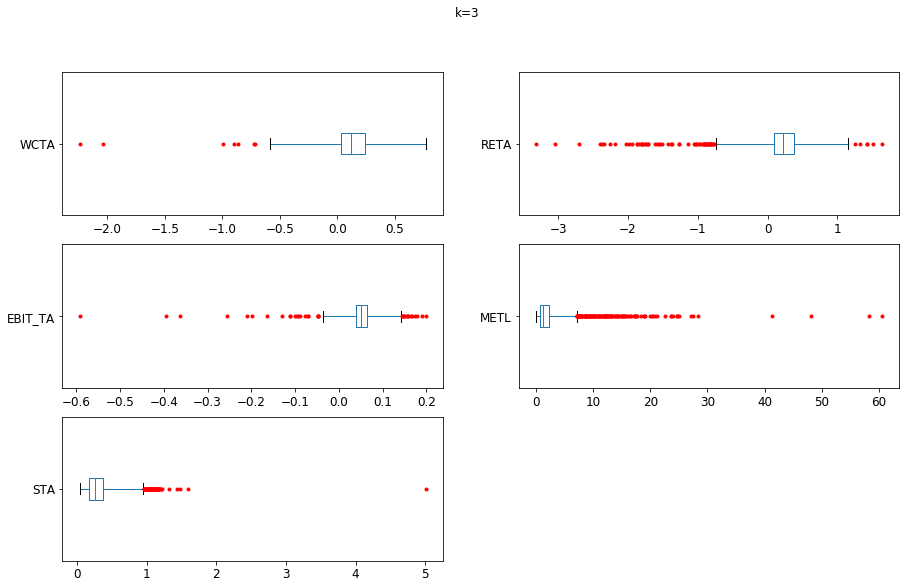

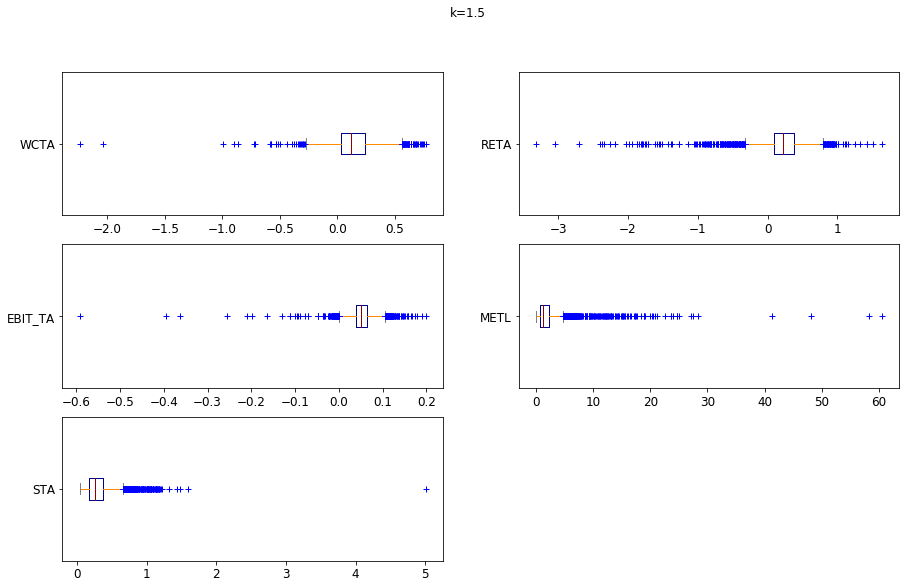

In [60]:
#https://pandas.pydata.org/pandas-docs/version/0.15.0/visualization.html
import matplotlib.pyplot as plt
color = dict(boxes='DarkBlue', whiskers='DarkOrange',medians='DarkRed', caps='Gray')
data1.plot(kind='box',subplots=True,layout=(3,2), figsize=(15,9), fontsize=12, sharex=False,sharey=False, vert=False,whis=3,sym='r.',title='k=3')
data1.plot(kind='box',subplots=True, color=color, layout=(3,2), figsize=(15,9), fontsize=12, sharex=False,sharey=False, vert=False,whis=1.5,sym='b+',title='k=1.5')
plt.show()

### Question 7

In [61]:
# Default, WCTA,RETA, EBITTA, METL, STA
data5=data.iloc[:,2:]
data5.describe()

,Default,WCTA,RETA,EBIT_TA,METL,STA
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.982000,0.142514,0.210467,0.051803,1.953963,0.303652
std,0.132968,0.170763,0.332549,0.029596,2.994475,0.205794
min,0.000000,-2.240268,-3.312420,-0.591821,0.023718,0.035858
25%,1.000000,0.031167,0.094744,0.038992,0.623493,0.170836
50%,1.000000,0.117273,0.218929,0.051563,1.136456,0.261037
75%,1.000000,0.241775,0.373417,0.065093,2.244287,0.366936
max,1.000000,0.766040,1.639646,0.198035,60.607150,5.007775


In [62]:
correlation=data5.corr()
print(correlation)

          Default      WCTA      RETA   EBIT_TA      METL       STA
Default  1.000000  0.069606  0.219986  0.142317  0.066827 -0.027463
WCTA     0.069606  1.000000  0.197591  0.181370  0.206344  0.247285
RETA     0.219986  0.197591  1.000000  0.329396  0.237152  0.080836
EBIT_TA  0.142317  0.181370  0.329396  1.000000  0.284614  0.251476
METL     0.066827  0.206344  0.237152  0.284614  1.000000  0.001656
STA     -0.027463  0.247285  0.080836  0.251476  0.001656  1.000000


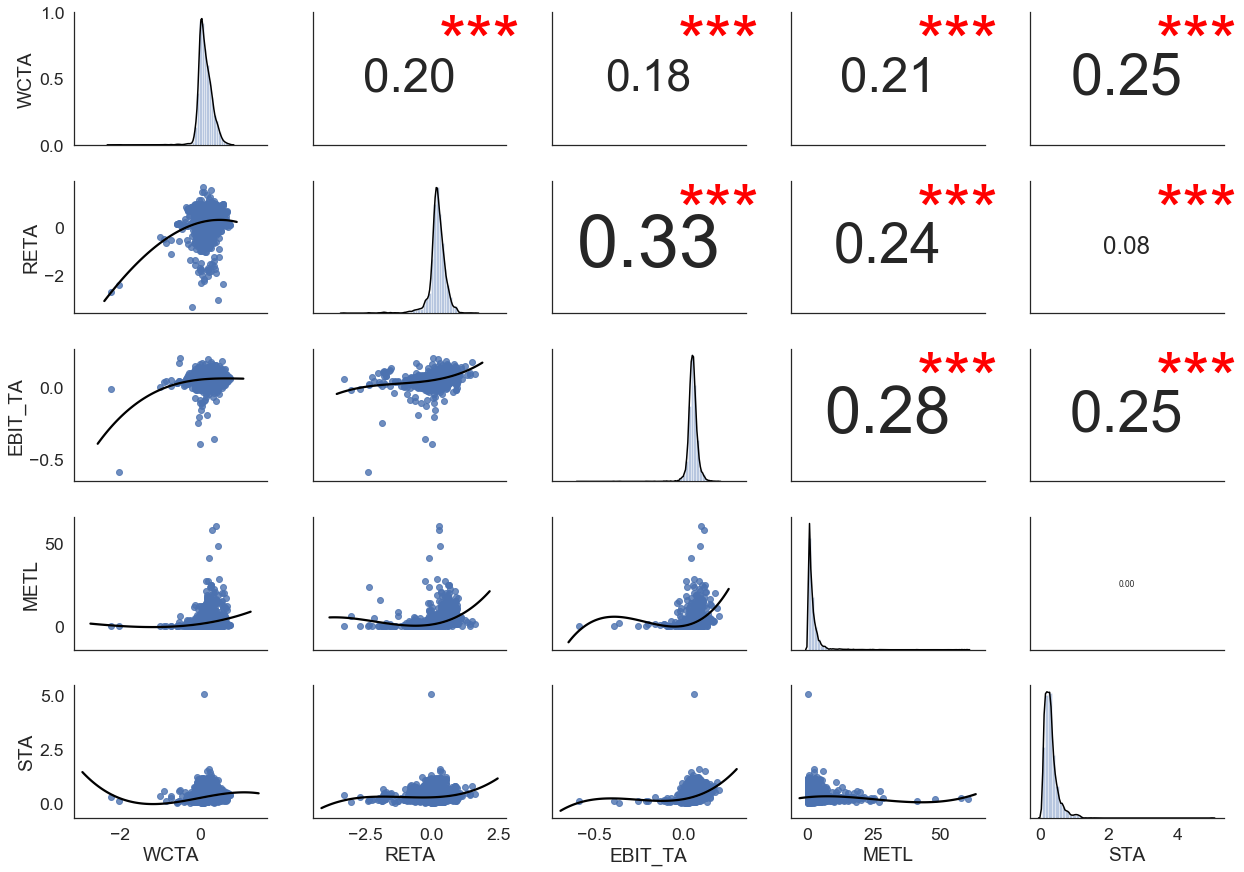

In [63]:
# Croisement des variables explicatives WCTA,RETA, EBITTA, METL, STA

import seaborn as sns
from scipy import stats

def corrdot(*args, **kwargs):
    #*args表示任何多个无名参数，它是一个tuple；**kwargs表示关键字参数，它是一个dict。并且同时使用*args和**kwargs时，必须*args参数列要在**kwargs前，像foo(a=1, b='2', c=3, a', 1, None, )这样调用的话，会提示语法错误
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}" #name = 'Eric'>>> f'Hello, my name is {name}'>>>'Hello, my name is Eric'
    ax = plt.gca()
    font_size = abs(corr_r) * 200+8
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)
    
def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes, color='red', fontsize=70)

sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(data1, aspect=1.4, diag_sharey=False)  #data1: correlations entre les variables explicatives
g.map_lower(sns.regplot, order=3, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
g.map_upper(corrfunc)

In [50]:
# croisement entre les variables explicatives et la variable à expliquer
import scipy.stats as stats

classification=data2['Default'].unique()

for i in classification:
    data_separe=data2[data2['Default'].isin([i])]
    exec("groupe_%s=data_separe"%i)
#print(groupe_0)
#print(groupe_1)

def test_MannWhitney_U(groupe1, groupe2):
    u,p_val=stats.mannwhitneyu(groupe1,groupe2,alternative='two-sided')
    print("U=%.2f, P value=%.4e"%(u,p_val))

for i in data1:
    print(i)
    #print(np.array(groupe_0[i]),len(np.array(groupe_0[i])),np.array(groupe_1[i]), len(np.array(groupe_1[i])))
    test_MannWhitney_U(np.array(groupe_0[i]), np.array(groupe_1[i]))

WCTA
U=126621.00, P value=1.2783e-01
RETA
U=37318.00, P value=8.2740e-27
EBIT_TA
U=74753.50, P value=6.6934e-12
METL
U=37159.00, P value=6.9307e-27
STA
U=156455.00, P value=1.2126e-01


https://zhuanlan.zhihu.com/p/52302383
https://cloud.tencent.com/developer/ask/137916
http://eric.univ-lyon2.fr/~ricco/cours/slides/PI%20-%20statistiques%20avec%20scipy.pdf

dayDf = borrowManageMoneyDf[borrowManageMoneyDf['pzType'].isin([1])]
monthDf = borrowManageMoneyDf[borrowManageMoneyDf['pzType'].isin([0])]

### Question 9

In [246]:
np.set_printoptions(precision=3, suppress=True) # change le format de chiffre dans numpy de .e à .f
#np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [267]:
# Normalisation des données

from sklearn import preprocessing
def standardisation_z_score (data):
    zscore=preprocessing.StandardScaler()
    data_zs=zscore.fit_transform(data)
    print ("mean: ", data_zs.mean (axis = 0))
    print ("standard: ",data_zs.std (axis = 0))
    return data_zs

In [268]:
# Création des "trains"  et "tests"

from sklearn.model_selection import StratifiedShuffleSplit
def StratifiedSplit_train_test (X,y,n_split, test_size, random_state):
    sss = StratifiedShuffleSplit(n_splits=n_split, test_size=test_size, random_state=random_state)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test    

In [347]:
# Recherche des meilleurs paramètres pour le modèle de régression logisitique: GridsearchCV
# en fonction de Accuracy + Cost_matrice

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

def cost_matrice(y_train,y_pred, score_TP,score_TN,score_FP,score_FN):
    tp=confusion_matrix(y_train, y_pred)[1, 1]
    tn=confusion_matrix(y_train, y_pred)[0, 0]
    fp=confusion_matrix(y_train, y_pred)[0, 1]
    fn=confusion_matrix(y_train, y_pred)[1, 0]
    cost=tp*score_TP+tn*score_TN-(fp*score_FP + fn*score_FN)
    return cost

def faulse_positive (y_train,y_pred):
    fp=confusion_matrix(y_train, y_pred)[0, 1]
    return -fp

def faulse_negative (y_train,y_pred):
    fn=confusion_matrix(y_train, y_pred)[1, 0]
    return -fn

def reg_log_gridsearchCV(X_train, y_train, parametres,cv,scoring,refit):
    rl=LogisticRegression(penalty='l2',class_weight='balanced',random_state=4)
    grid= GridSearchCV(estimator=rl, param_grid=parametres,cv=cv, scoring=scoring,refit=refit)
    grid.fit(X_train,y_train)
    return pd.DataFrame(grid.cv_results_), grid.best_params_

In [352]:
# Régression logistique avec les paramètres déterminés par GridsearchCV

def regression_logistique (data, X_train, y_train, X_test, y_test, C,penalty, solver, class_weight,random_state):
    model=LogisticRegression(C=C,penalty=penalty,solver=solver,class_weight=class_weight, random_state=random_state)
    model.fit(X_train,y_train)
    coef_df=pd.DataFrame(np.transpose(model.coef_), data.columns, columns=['coefficients'])
    print(coef_df)
    print("intercept: ", model.intercept_)
    y_pred=model.predict(X_test)
    y_pred_proba=model.predict_proba(X_test)
    acc=accuracy_score(y_test, y_pred)
    print("Accuracy = %.3f "%(acc))
    return y_pred,y_pred_proba

In [320]:
# Matrice de confusion

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def confusionmatrix (y_test,y_pred):
    cnf_matrix=confusion_matrix(y_test,y_pred)
    print (cnf_matrix)
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.yticks(np.arange(2), ['0','1'])
    plt.xticks(np.arange(2), ['0','1'])
    plt.show()

In [321]:
# Courbe ROC et AUC

from sklearn.metrics import roc_curve,auc
def ROC_AUC (y_test,y_pred_proba):
    fpr,tpr,thresholds=roc_curve(y_test,y_pred_proba[:, 1], drop_intermediate=True) # y_pred_proba[p(0),p(1)]
    print("fpr",fpr.shape,"tpr", tpr.shape,"thresholds",thresholds.shape)
    auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (0,auc(fpr, tpr) ))
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.legend(loc='lower right')
    plt.show()

          WCTA      RETA   EBIT_TA      METL       STA
0     0.500799  0.306846  0.043373  0.956271  0.334774
1     0.547780  0.322214  0.051843  1.064545  0.334591
2     0.451001  0.225150  0.026813  0.804096  0.245585
3     0.306887  0.191936  0.030058  0.387010  0.253438
4     0.447246  0.217368  0.032458  0.791639  0.275531
...        ...       ...       ...       ...       ...
3995  0.028728 -1.846117  0.033956  0.034680  0.678044
3996  0.172167 -0.068613 -0.004699  0.043519  0.235299
3997  0.005588 -0.260068  0.036878  0.298255  0.148100
3998 -0.994230 -0.433532 -0.000244  0.035502  0.330467
3999  0.065566 -0.113739  0.036024  0.037632  0.116360

[4000 rows x 5 columns]
mean:  [ 0.  0.  0.  0. -0.]
standard:  [1. 1. 1. 1. 1.]
params_best {'C': 0.0001, 'solver': 'lbfgs'}
         coefficients
WCTA         0.018201
RETA         0.094331
EBIT_TA      0.061822
METL         0.032900
STA         -0.021101
intercept:  [0.114]
Accuracy = 0.904 
[[ 11   3]
 [ 74 712]]


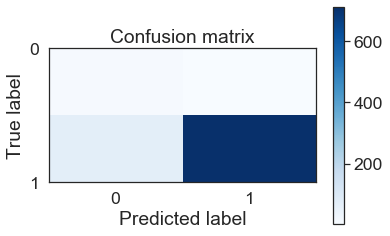

fpr (27,) tpr (27,) thresholds (27,)


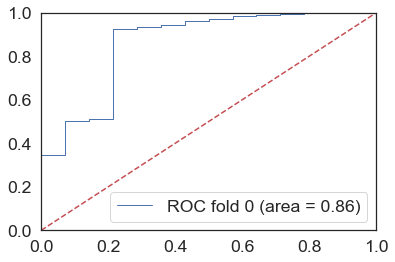

****************************************************************************************************
          WCTA      RETA   EBIT_TA       STA
0     0.500799  0.306846  0.043373  0.334774
1     0.547780  0.322214  0.051843  0.334591
2     0.451001  0.225150  0.026813  0.245585
3     0.306887  0.191936  0.030058  0.253438
4     0.447246  0.217368  0.032458  0.275531
...        ...       ...       ...       ...
3995  0.028728 -1.846117  0.033956  0.678044
3996  0.172167 -0.068613 -0.004699  0.235299
3997  0.005588 -0.260068  0.036878  0.148100
3998 -0.994230 -0.433532 -0.000244  0.330467
3999  0.065566 -0.113739  0.036024  0.116360

[4000 rows x 4 columns]
mean:  [ 0.  0.  0. -0.]
standard:  [1. 1. 1. 1.]
params_best {'C': 0.0001, 'solver': 'lbfgs'}
         coefficients
WCTA         0.018593
RETA         0.095010
EBIT_TA      0.062391
STA         -0.021227
intercept:  [0.107]
Accuracy = 0.907 
[[ 11   3]
 [ 71 715]]


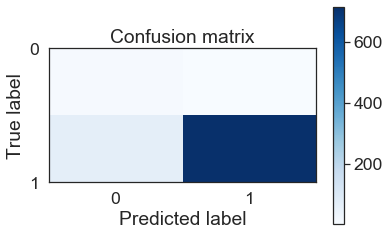

fpr (27,) tpr (27,) thresholds (27,)


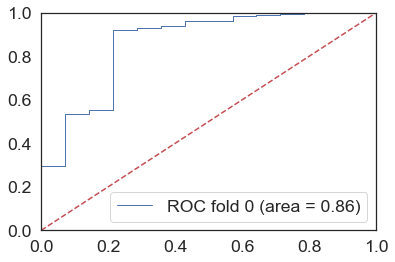

****************************************************************************************************
          METL   EBIT_TA
0     0.956271  0.043373
1     1.064545  0.051843
2     0.804096  0.026813
3     0.387010  0.030058
4     0.791639  0.032458
...        ...       ...
3995  0.034680  0.033956
3996  0.043519 -0.004699
3997  0.298255  0.036878
3998  0.035502 -0.000244
3999  0.037632  0.036024

[4000 rows x 2 columns]
mean:  [0. 0.]
standard:  [1. 1.]
params_best {'C': 0.0001, 'solver': 'lbfgs'}
         coefficients
METL         0.035467
EBIT_TA      0.068856
intercept:  [0.047]
Accuracy = 0.790 
[[  7   7]
 [161 625]]


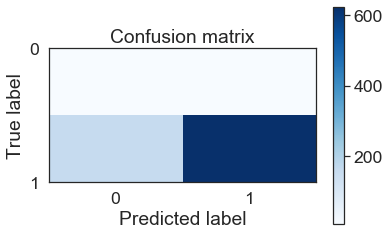

fpr (29,) tpr (29,) thresholds (29,)


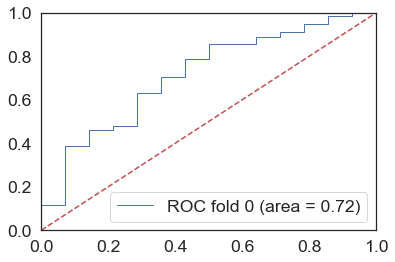

****************************************************************************************************
          WCTA      RETA
0     0.500799  0.306846
1     0.547780  0.322214
2     0.451001  0.225150
3     0.306887  0.191936
4     0.447246  0.217368
...        ...       ...
3995  0.028728 -1.846117
3996  0.172167 -0.068613
3997  0.005588 -0.260068
3998 -0.994230 -0.433532
3999  0.065566 -0.113739

[4000 rows x 2 columns]
mean:  [0. 0.]
standard:  [1. 1.]
params_best {'C': 0.0001, 'solver': 'lbfgs'}
      coefficients
WCTA      0.024632
RETA      0.099081
intercept:  [0.076]
Accuracy = 0.895 
[[ 11   3]
 [ 81 705]]


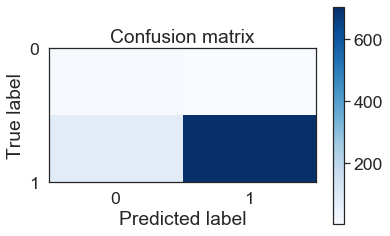

fpr (31,) tpr (31,) thresholds (31,)


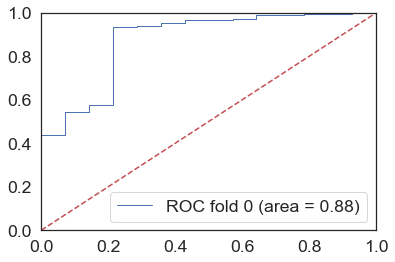

****************************************************************************************************


In [357]:
param_grid = {'C': [0.0001,0.001,0.01,0.1,1,10,100,1000],'solver':['liblinear','lbfgs']}
my_scorer = {'Accuracy' : 'accuracy','cost_matrice':make_scorer(cost_matrice,score_TP=1,score_TN=1,
                                        score_FP=5,score_FN=3,greater_is_better=True)}

for i in data_rassemble.values(): 
    print(i)
    data_zs=standardisation_z_score(i)
    X_train,X_test, y_train, y_test=StratifiedSplit_train_test(X=data_zs,y=np.array(data['Default']),n_split=1,
                                                               test_size=0.2, random_state=2)
    resultats,params_best=reg_log_gridsearchCV(X_train=X_train, y_train=y_train, 
                                               parametres=param_grid,
                                               cv=3,scoring='accuracy',refit=True)
    print("params_best",params_best)
    y_pred,y_pred_proba=regression_logistique(data=i, X_train=X_train, y_train=y_train, 
                                              X_test=X_test, y_test=y_test,
                                              C=params_best['C'], penalty='l2', solver=params_best['solver'], 
                                              class_weight='balanced',random_state=4)
    confusionmatrix(y_test,y_pred)
    ROC_AUC (y_test,y_pred_proba)
    print(100*'*')

## -----------------------------------------fin de projet-----------------------------------------------------------------------

In [239]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

def cost_matrice(y_train,y_pred, score_TP,score_TN,score_FP,score_FN):
    tp=confusion_matrix(y_train, y_pred)[1, 1]
    tn=confusion_matrix(y_train, y_pred)[0, 0]
    fp=confusion_matrix(y_train, y_pred)[0, 1]
    fn=confusion_matrix(y_train, y_pred)[1, 0]
    cost=(tp*score_TP + tn*score_TN)-(fp*score_FP + fn*score_FN)
    return cost

def cost_matrice_2(y_train,y_pred):
    fp=confusion_matrix(y_train, y_pred)[0, 1]
    return -fp

def reg_log_gridsearchCV(X_train, y_train, parametres,cv,scoring,refit):
    zscore=preprocessing.StandardScaler()
    X_train_zs=zscore.fit_transform(X_train)
    rl=LogisticRegression(penalty='l2',class_weight='balanced',random_state=2)
    grid= GridSearchCV(estimator=rl, param_grid=parametres,cv=cv, scoring=scoring,refit=refit)
    grid.fit(X_train_zs,y_train)
    return pd.DataFrame(grid.cv_results_), grid.best_params_

In [240]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'solver':['liblinear','lbfgs']}
my_scorer = {'accuracy' : 'accuracy', 'cost_matrice':make_scorer(cost_matrice,
                                                                   score_TP=1,score_TN=1, score_FP=2.5,score_FN=1.5,
                                                                   greater_is_better=True)}
my_scorer_2 = {'accuracy' : 'accuracy', 'cost_matrice':make_scorer(cost_matrice_2,
                                                                   greater_is_better=True)}

In [241]:
X_train=np.array(data1)
y_train=np.array(data['Default'])

In [245]:
resultats,params_best=reg_log_gridsearchCV(X_train=X_train, y_train=y_train, parametres=param_grid,cv=3,scoring=my_scorer_2,refit='cost_matrice')
resultats

C:\Users\Imsd\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_solver,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_cost_matrice,split1_test_cost_matrice,split2_test_cost_matrice,mean_test_cost_matrice,std_test_cost_matrice,rank_test_cost_matrice
0,0.003656,4.693493e-04,0.002992,8.136156e-04,0.001,liblinear,"{'C': 0.001, 'solver': 'liblinear'}",0.737631,0.682671,0.633158,0.68450,0.042673,14,-1.0,-7.0,0.0,-2.66625,3.090932,1
1,0.006649,4.695770e-04,0.002991,8.149803e-04,0.001,lbfgs,"{'C': 0.001, 'solver': 'lbfgs'}",0.905547,0.857464,0.864216,0.87575,0.021257,1,-6.0,-8.0,-1.0,-5.00025,2.943595,14
2,0.005666,2.490996e-03,0.002979,1.578772e-05,0.01,liblinear,"{'C': 0.01, 'solver': 'liblinear'}",0.872564,0.814704,0.783196,0.82350,0.037013,13,-3.0,-7.0,0.0,-3.33325,2.867088,2
3,0.004986,8.920806e-07,0.001994,8.778064e-07,0.01,lbfgs,"{'C': 0.01, 'solver': 'lbfgs'}",0.900300,0.842461,0.819955,0.85425,0.033845,2,-6.0,-8.0,0.0,-4.66700,3.398987,13
4,0.004987,8.135189e-04,0.002328,4.705277e-04,0.1,liblinear,"{'C': 0.1, 'solver': 'liblinear'}",0.894303,0.837959,0.804201,0.84550,0.037170,12,-5.0,-7.0,0.0,-4.00025,2.943595,3
5,0.007646,2.351288e-03,0.001663,9.421789e-04,0.1,lbfgs,"{'C': 0.1, 'solver': 'lbfgs'}",0.895802,0.840960,0.812453,0.84975,0.034592,3,-6.0,-7.0,0.0,-4.33375,3.090932,12
6,0.004321,9.397062e-04,0.002328,4.706398e-04,1,liblinear,"{'C': 1, 'solver': 'liblinear'}",0.895052,0.838710,0.808702,0.84750,0.035798,11,-5.0,-7.0,0.0,-4.00025,2.943595,3
7,0.007647,1.243985e-03,0.002328,4.687857e-04,1,lbfgs,"{'C': 1, 'solver': 'lbfgs'}",0.895802,0.838710,0.808702,0.84775,0.036130,4,-5.0,-7.0,0.0,-4.00025,2.943595,3
8,0.004654,1.243518e-03,0.001994,9.989584e-07,10,liblinear,"{'C': 10, 'solver': 'liblinear'}",0.895802,0.838710,0.808702,0.84775,0.036130,4,-5.0,-7.0,0.0,-4.00025,2.943595,3
9,0.007981,8.157561e-04,0.002326,9.401127e-04,10,lbfgs,"{'C': 10, 'solver': 'lbfgs'}",0.895802,0.838710,0.808702,0.84775,0.036130,4,-5.0,-7.0,0.0,-4.00025,2.943595,3


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

def reg_log_gridsearchCV(X_train, y_train, parametres,cv,scoring):
    rl=LogisticRegression(penalty='l2', class_weight='balanced')
    zscore=preprocessing.StandardScaler()
    data_zs=zscore.fit_transform(X_train)
    grid= GridSearchCV(estimator=rl, param_grid=parametres,cv=cv, scoring=scoring)
    grid.fit(data_zs,y_train)
    return pd.DataFrame(grid.cv_results_)

In [155]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'solver':['liblinear','lbfgs']}
resultat=reg_log_gridsearchCV(X_train, y_train, param_grid,3,'accuracy')
resultat

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002991,1.325077e-06,0.000333,4.709208e-04,0.001,liblinear,"{'C': 0.001, 'solver': 'liblinear'}",0.737631,0.682671,0.633158,0.68450,0.042673,14
1,0.005650,4.677738e-04,0.000998,2.245020e-06,0.001,lbfgs,"{'C': 0.001, 'solver': 'lbfgs'}",0.905547,0.857464,0.864216,0.87575,0.021257,1
2,0.005323,9.339742e-04,0.000329,4.647392e-04,0.01,liblinear,"{'C': 0.01, 'solver': 'liblinear'}",0.872564,0.814704,0.783196,0.82350,0.037013,13
3,0.006982,1.411357e-03,0.000332,4.700217e-04,0.01,lbfgs,"{'C': 0.01, 'solver': 'lbfgs'}",0.900300,0.842461,0.819955,0.85425,0.033845,2
4,0.003656,4.699655e-04,0.000333,4.702464e-04,0.1,liblinear,"{'C': 0.1, 'solver': 'liblinear'}",0.894303,0.837959,0.804201,0.84550,0.037170,12
5,0.005984,8.153668e-04,0.000333,4.705836e-04,0.1,lbfgs,"{'C': 0.1, 'solver': 'lbfgs'}",0.895802,0.840960,0.812453,0.84975,0.034592,3
6,0.004321,9.403805e-04,0.000665,4.703590e-04,1,liblinear,"{'C': 1, 'solver': 'liblinear'}",0.895052,0.838710,0.808702,0.84750,0.035798,11
7,0.006317,4.699655e-04,0.000000,0.000000e+00,1,lbfgs,"{'C': 1, 'solver': 'lbfgs'}",0.895802,0.838710,0.808702,0.84775,0.036130,4
8,0.003324,4.703027e-04,0.000665,4.702466e-04,10,liblinear,"{'C': 10, 'solver': 'liblinear'}",0.895802,0.838710,0.808702,0.84775,0.036130,4
9,0.007978,2.973602e-07,0.000333,4.705836e-04,10,lbfgs,"{'C': 10, 'solver': 'lbfgs'}",0.895802,0.838710,0.808702,0.84775,0.036130,4


In [110]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(base_estimator=, n_estimators=100,algorithm='SAMME', )
scores = cross_val_score(clf, iris.data, iris.target)
scores.mean()   

SyntaxError: invalid syntax (<ipython-input-110-1f4d54f55e66>, line 4)

In [ ]:
X=np.mat(data)
print(type(X))

y=data['Default']
beta_0 = np.ones(y.shape)
X=np.column_stack((beta_0,data_zs))
X = np.mat(X) #création de la matrice
#print(X[1,2]) #troisième valeur de la première ligne : 0.3360720802298659
print(X)

          WCTA      RETA   EBIT_TA      METL       STA
0     0.500799  0.306846  0.043373  0.956271  0.334774
1     0.547780  0.322214  0.051843  1.064545  0.334591
2     0.451001  0.225150  0.026813  0.804096  0.245585
3     0.306887  0.191936  0.030058  0.387010  0.253438
4     0.447246  0.217368  0.032458  0.791639  0.275531
...        ...       ...       ...       ...       ...
3995  0.028728 -1.846117  0.033956  0.034680  0.678044
3996  0.172167 -0.068613 -0.004699  0.043519  0.235299
3997  0.005588 -0.260068  0.036878  0.298255  0.148100
3998 -0.994230 -0.433532 -0.000244  0.035502  0.330467
3999  0.065566 -0.113739  0.036024  0.037632  0.116360

[4000 rows x 5 columns]
mean:  [ 0.  0.  0.  0. -0.]
standard:  [1. 1. 1. 1. 1.]
         coefficients
WCTA         0.015813
RETA         0.060385
EBIT_TA      0.043703
METL         0.019519
STA         -0.011599
intercept:  [1.822]
Accuracy = 0.983 
y_pred_proba [0.167 0.833]
0
1
[[  0  14]
 [  0 786]]


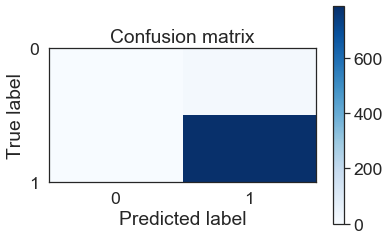

fpr [0.    0.    0.    0.071 0.071 0.143 0.143 0.214 0.214 0.286 0.286 0.357
 0.357 0.429 0.429 0.5   0.5   0.571 0.571 0.643 0.643 0.714 0.714 0.786
 0.786 1.    1.   ] tpr [0.    0.001 0.302 0.302 0.505 0.505 0.519 0.519 0.925 0.925 0.931 0.931
 0.941 0.941 0.959 0.959 0.971 0.971 0.985 0.985 0.991 0.991 0.995 0.995
 0.999 0.999 1.   ] thresholds [1.91  0.91  0.865 0.865 0.861 0.861 0.86  0.86  0.85  0.849 0.849 0.849
 0.848 0.848 0.844 0.843 0.841 0.841 0.834 0.833 0.829 0.829 0.825 0.824
 0.816 0.8   0.757]


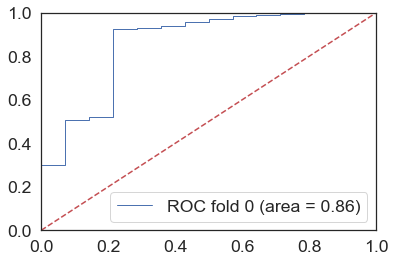

****************************************************************************************************
          WCTA      RETA   EBIT_TA       STA
0     0.500799  0.306846  0.043373  0.334774
1     0.547780  0.322214  0.051843  0.334591
2     0.451001  0.225150  0.026813  0.245585
3     0.306887  0.191936  0.030058  0.253438
4     0.447246  0.217368  0.032458  0.275531
...        ...       ...       ...       ...
3995  0.028728 -1.846117  0.033956  0.678044
3996  0.172167 -0.068613 -0.004699  0.235299
3997  0.005588 -0.260068  0.036878  0.148100
3998 -0.994230 -0.433532 -0.000244  0.330467
3999  0.065566 -0.113739  0.036024  0.116360

[4000 rows x 4 columns]
mean:  [ 0.  0.  0. -0.]
standard:  [1. 1. 1. 1.]
         coefficients
WCTA         0.015977
RETA         0.060599
EBIT_TA      0.043929
STA         -0.011617
intercept:  [1.82]
Accuracy = 0.983 
y_pred_proba [0.166 0.834]
0
1
[[  0  14]
 [  0 786]]


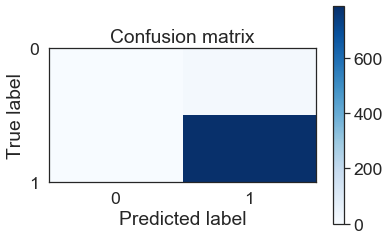

fpr [0.    0.    0.    0.071 0.071 0.143 0.143 0.214 0.214 0.286 0.286 0.357
 0.357 0.429 0.429 0.5   0.5   0.571 0.571 0.643 0.643 0.714 0.714 0.786
 0.786 1.    1.   ] tpr [0.    0.001 0.239 0.239 0.536 0.536 0.548 0.548 0.919 0.919 0.926 0.926
 0.94  0.94  0.959 0.959 0.964 0.964 0.985 0.985 0.989 0.989 0.995 0.995
 0.999 0.999 1.   ] thresholds [1.902 0.902 0.867 0.866 0.86  0.86  0.86  0.86  0.851 0.851 0.85  0.85
 0.849 0.849 0.845 0.845 0.843 0.842 0.835 0.834 0.831 0.831 0.826 0.825
 0.817 0.802 0.758]


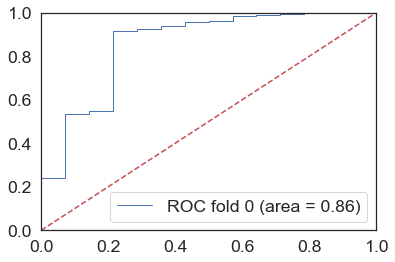

****************************************************************************************************
          METL   EBIT_TA
0     0.956271  0.043373
1     1.064545  0.051843
2     0.804096  0.026813
3     0.387010  0.030058
4     0.791639  0.032458
...        ...       ...
3995  0.034680  0.033956
3996  0.043519 -0.004699
3997  0.298255  0.036878
3998  0.035502 -0.000244
3999  0.037632  0.036024

[4000 rows x 2 columns]
mean:  [0. 0.]
standard:  [1. 1.]
         coefficients
METL         0.020376
EBIT_TA      0.047180
intercept:  [1.806]
Accuracy = 0.983 
y_pred_proba [0.153 0.847]
0
1
[[  0  14]
 [  0 786]]


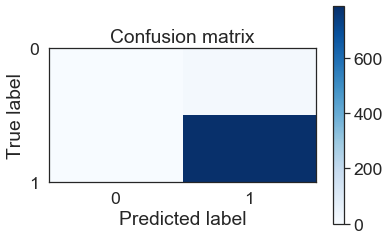

fpr [0.    0.    0.    0.071 0.071 0.143 0.143 0.214 0.214 0.286 0.286 0.357
 0.357 0.429 0.429 0.5   0.5   0.571 0.571 0.643 0.643 0.714 0.714 0.786
 0.786 0.857 0.857 0.929 0.929 1.    1.   ] tpr [0.    0.001 0.106 0.106 0.369 0.369 0.472 0.472 0.485 0.485 0.608 0.608
 0.696 0.696 0.779 0.779 0.85  0.85  0.856 0.856 0.88  0.88  0.91  0.91
 0.95  0.95  0.986 0.986 0.999 0.999 1.   ] thresholds [1.908 0.908 0.866 0.866 0.86  0.86  0.859 0.859 0.859 0.859 0.857 0.857
 0.857 0.857 0.855 0.855 0.854 0.854 0.854 0.854 0.854 0.854 0.853 0.853
 0.851 0.851 0.847 0.847 0.839 0.837 0.835]


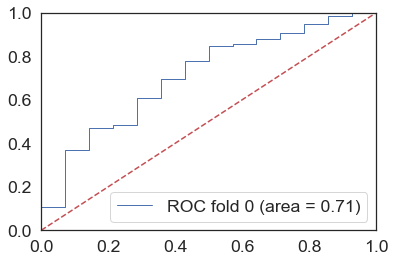

****************************************************************************************************
          WCTA      RETA
0     0.500799  0.306846
1     0.547780  0.322214
2     0.451001  0.225150
3     0.306887  0.191936
4     0.447246  0.217368
...        ...       ...
3995  0.028728 -1.846117
3996  0.172167 -0.068613
3997  0.005588 -0.260068
3998 -0.994230 -0.433532
3999  0.065566 -0.113739

[4000 rows x 2 columns]
mean:  [0. 0.]
standard:  [1. 1.]
      coefficients
WCTA      0.018346
RETA      0.062529
intercept:  [1.81]
Accuracy = 0.983 
y_pred_proba [0.154 0.846]
0
1
[[  0  14]
 [  0 786]]


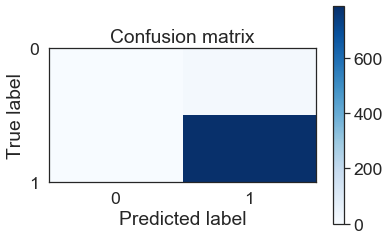

fpr [0.    0.    0.    0.071 0.071 0.143 0.143 0.214 0.214 0.286 0.286 0.357
 0.357 0.429 0.429 0.571 0.571 0.643 0.643 0.786 0.786 0.857 0.857 0.929
 0.929 1.    1.   ] tpr [0.    0.001 0.411 0.411 0.547 0.547 0.573 0.573 0.938 0.938 0.94  0.94
 0.954 0.954 0.968 0.968 0.972 0.972 0.992 0.992 0.994 0.994 0.996 0.996
 0.999 0.999 1.   ] thresholds [1.888 0.888 0.861 0.861 0.859 0.859 0.859 0.859 0.851 0.851 0.851 0.851
 0.849 0.848 0.846 0.846 0.844 0.844 0.829 0.826 0.823 0.822 0.816 0.813
 0.807 0.793 0.753]


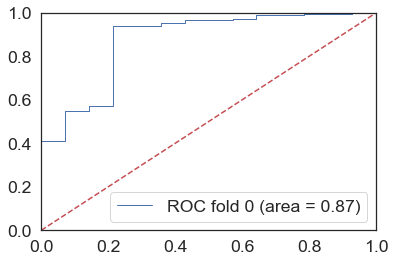

****************************************************************************************************


In [61]:
for i in data_rassemble.values(): 
    print(i)
    data_zs=standardisation_z_score(i)
    X_train,X_test, y_train, y_test=StratifiedSplit_train_test(data_zs,np.array(data['Default']),1, 0.2, 2)
    y_pred,y_pred_proba=regression_logistique_CV (i, X_train, y_train, X_test, y_test, 1,3, 'l2', 'lbfgs', {0:9,1:1}, 3)
    confusionmatrix(y_test,y_pred)
    ROC_AUC (y_test,y_pred_proba)
    print(100*'*')

In [41]:
import numpy as np
from sklearn.metrics import roc_curve,auc
y_valeur=np.array([1,1,0,1,0,0,0,1])
y_score=np.array([0.2,0.5,0.7,0.66,0.45,0.23,0.31,0.8])
fpr,tpr,thresholds=roc_curve(y_valeur,y_score,drop_intermediate=False)
#“threshold[0]”表示没有预测到任何实例，并被任意设置为“max(y_score) + 1”
#roc_curve()方法在调用时，可以传入参数drop_intermediate，其默认值为True即减少次优阈值，可以通过设置其为False返回所有阈值。
#drop_intermediate参数的解释为：是否降低一些不会出现在绘制的ROC曲线上的次优阈值。这对于创造更清楚的ROC曲线是有用的。

In [42]:
print(fpr)

[0.   0.   0.25 0.25 0.25 0.5  0.75 1.   1.  ]


In [43]:
print(tpr)

[0.   0.25 0.25 0.5  0.75 0.75 0.75 0.75 1.  ]


In [44]:
print(thresholds)

[1.8  0.8  0.7  0.66 0.5  0.45 0.31 0.23 0.2 ]


In [38]:
import pandas as pd
pd=pd.DataFrame(np.stack((y_valeur,y_score),axis=1),columns=['y_valeur','y_score'])
pd

,y_valeur,y_score
0,1.0,0.20
1,1.0,0.50
2,0.0,0.70
3,1.0,0.66
4,0.0,0.45
5,0.0,0.23
6,0.0,0.31
7,1.0,0.80


In [40]:
pd1=pd.sort_values(by=['y_score'],ascending=False,inplace=False)
pd1

,y_valeur,y_score
7,1.0,0.80
2,0.0,0.70
3,1.0,0.66
1,1.0,0.50
4,0.0,0.45
6,0.0,0.31
5,0.0,0.23
0,1.0,0.20


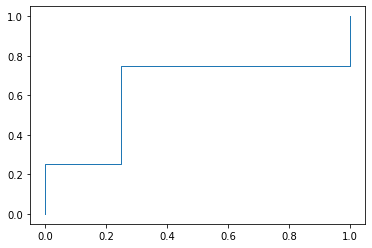

In [45]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (0,auc(fpr, tpr) ))